# Detection of Bruxism events in Tinnitus patients polysomnographic data
This notebook will 
- load EMG channels of polysomnographic data
- detect the EMG bursts in a unsupervised way
- classify EMG bursts as different bruxism events
- give insights on the bruxism events

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np
import mne
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw, RawToEpochs_sliding, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.signal import rms
from tinnsleep.utils import fuse_with_classif_result, merge_labels_list
from tinnsleep.reports import preprocess, generate_bruxism_report
import pandas as pd
print("Config loaded")
#print(Config.bruxisme_files)
# search index for specific subject
subjects = ['HZB nuit 2 resmed.edf']
print([(filename.split(os.path.sep)[-1], i) for i, filename in enumerate(Config.bruxisme_files) if filename.split(os.path.sep)[-1] in subjects])

Config loaded
[]


## Load

In [3]:
from ast import literal_eval
filename = Config.bruxisme_files[26]  # load file from config
raw = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
file = filename.split(os.path.sep)[-1]
data_info = pd.read_csv("data/data_info.csv", engine='python', sep=";")
data_info["Valid_chans"] = data_info["Valid_chans"].apply(literal_eval)
data_info["Valid_imps"] = data_info["Valid_imps"].apply(literal_eval)
#mema_files = pd.read_csv("data/mema_files.csv", engine='python', sep="; ")["files_with_mema"].values
#dico_chans = pd.read_pickle("data/valid_chans_THR_imp.pk").to_dict("list")  # TODO: check if valid for all subjects
#print(data_info["Valid_imps"])
dico_chans = data_info.set_index('filename')[["Valid_chans", "Valid_imps", "THR_IMP"]]
#print(dico_chans)

<ipython-input-3-0d0525c8e659>:3: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading


## Parameters

In [4]:
picks_chan_bruxism = ['1', '2']
picks_imp = ['1 Imp?dance', '2 Imp?dance']
THR_imp = 2e4

window_length_common = 0.25
duration_factor_OMA = 4
duration_factor_Impedance = 4
n_adaptive_bruxism = -60
# ----------------- Prepare parameters -----------------------------------------------
duration_bruxism = int(window_length_common * raw.info['sfreq'])  # in sample
window_length_bruxism = duration_bruxism / raw.info['sfreq']  # recompute exact window_length
duration_OMA = duration_factor_OMA * duration_bruxism
duration_Impedance = duration_factor_Impedance * duration_bruxism
n_adaptive_bruxism = int(n_adaptive_bruxism / window_length_bruxism)

log = {}


## Display raw

[('1', 0), ('2', 6), ('Activity', 11), ('Airflow', 43)]
2 (FIFFV_EEG_CH)


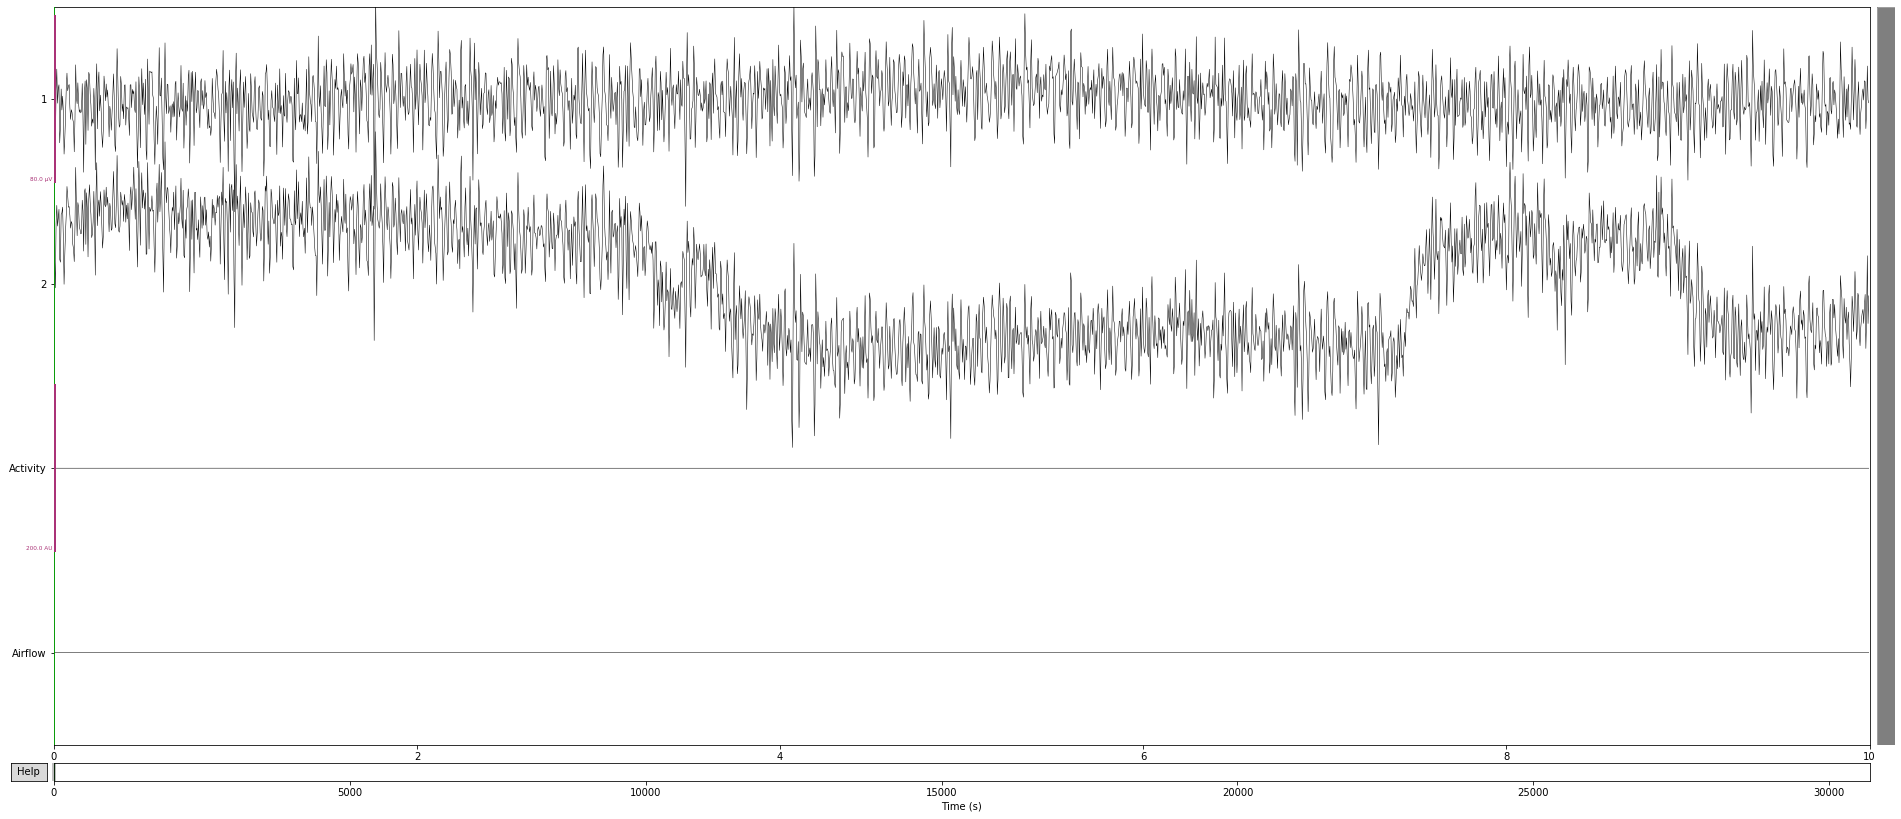

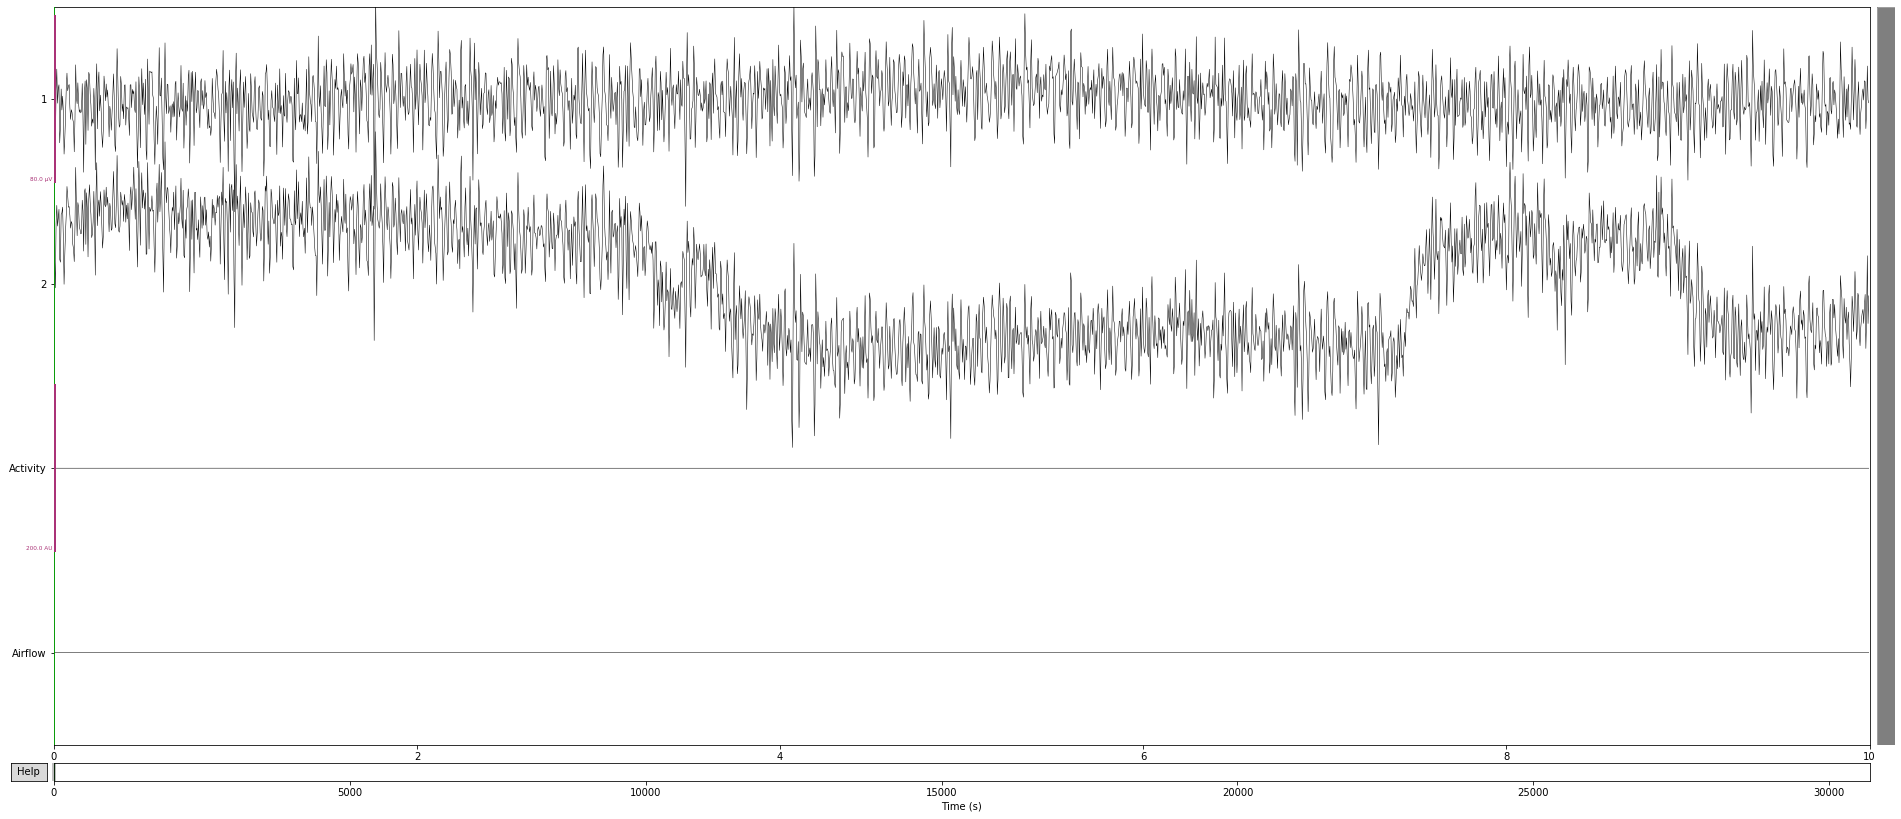

In [5]:
scalings = dict(misc=1e2, emg = 4e-5)
all_channels = picks_chan_bruxism + ['Activity', 'Airflow']
mapping_type = {}; 
for ch in picks_chan_bruxism:
    mapping_type[ch]='emg'
mapping_type['Activity'] = 'misc'
mapping_type['Airflow'] = 'misc'
raw.set_channel_types(mapping_type)

print([(chan, i) for i, chan in enumerate(raw.info["ch_names"]) if chan in all_channels])
print(raw.info["chs"][35]['kind'])

raw.copy().pick(picks=all_channels).plot(scalings=scalings)



## Process raw and epoch
- will additionally detect flat and artifacts

In [6]:
valid_labels_bruxism = []
is_good_kwargs = dict(ch_names=picks_chan_bruxism,
                                          rejection_thresholds=dict(emg=7e-04),  # two order of magnitude higher q0.01
                                          flat_thresholds=dict(emg=3e-09),  # one order of magnitude lower median
                                          channel_type_idx=dict(emg=[i for i in range(len(picks_chan_bruxism))])
                      )
filter_kwargs_emg = dict(l_freq=20., h_freq=99., n_jobs=4,
                     fir_design='firwin', filter_length='auto', phase='zero-double',
                     picks=picks_chan_bruxism)
epochs, valid_labels, log["bruxism"] = preprocess(raw, duration_bruxism,
                                                          duration_bruxism,
                                                          picks_chan=picks_chan_bruxism,
                                                          is_good_kwargs=is_good_kwargs,
                                                          filter_kwargs=filter_kwargs_emg)
valid_labels_bruxism.append(valid_labels)
print(f"Valid EMG for {np.sum(valid_labels)} epochs out of {len(valid_labels)} ({np.sum(valid_labels)/len(valid_labels)*100:.2f}%)")
AnnotateRaw_sliding(raw, np.invert(valid_labels), dict_annotations= {1: "min-max"}, duration=duration_bruxism , interval=duration_bruxism, merge=True)

Valid EMG for 123698 epochs out of 123709 (99.99%)


<RawEDF | 1PT06_nuit_son.edf, 84 x 7670000 (30680.0 s), ~167 kB, data not loaded>

## Detect movement artifacts

In [7]:
filter_kwargs = dict(l_freq=0.25, h_freq=16., n_jobs=4,
                     fir_design='firwin', filter_length='auto', phase='zero-double',
                     picks=['Activity'])
_, valid_labels_OMA, log["OMA"] = preprocess(raw, duration_OMA, duration_OMA,
                                             picks_chan=["Activity"],
                                             filter_kwargs=filter_kwargs,
                                             Thresholding_kwargs=dict(abs_threshold=0,
                                                                      rel_threshold=3,
                                                                      decision_function=lambda
                                                                          foo: np.any(
                                                                          foo > 0, axis=-1)),
                                             burst_to_episode_kwargs=dict(min_burst_joining=0,
                                                                          delim=3)
                                             )
valid_labels_bruxism.append(valid_labels_OMA)
print(f"Valid movement for {np.sum(valid_labels_OMA)} epochs out of {len(valid_labels_OMA)} ({np.sum(valid_labels_OMA)/len(valid_labels_OMA)*100:.2f}%)")
AnnotateRaw_sliding(raw, np.invert(valid_labels_OMA), dict_annotations= {1: "OMA"}, duration=duration_OMA , interval=duration_OMA, merge=True)

Valid movement for 30358 epochs out of 30927 (98.16%)


<RawEDF | 1PT06_nuit_son.edf, 84 x 7670000 (30680.0 s), ~167 kB, data not loaded>

## Detect bad impedance

In [8]:
_, valid_labels_IMP, log["IMP"] = preprocess(raw, duration_Impedance, duration_Impedance,
                                             picks_chan=picks_imp,

                                             Thresholding_kwargs=dict(abs_threshold=THR_imp,
                                                                      rel_threshold=0,
                                                                      decision_function=lambda
                                                                          foo: np.any(
                                                                          foo > 0, axis=-1)),
                                             burst_to_episode_kwargs=dict(min_burst_joining=0,
                                                                          delim=1)
                                             )
valid_labels_bruxism.append(valid_labels_IMP)
print(f"Valid EMG impedances for {np.sum(valid_labels_IMP)} epochs out of {len(valid_labels_IMP)} ({np.sum(valid_labels_IMP)/len(valid_labels_IMP)*100:.2f}%)")
AnnotateRaw_sliding(raw, np.invert(valid_labels_IMP), dict_annotations= {1: "IMP"}, duration=duration_Impedance , interval=duration_Impedance, merge=True)

Valid EMG impedances for 30927 epochs out of 30927 (100.00%)


<RawEDF | 1PT06_nuit_son.edf, 84 x 7670000 (30680.0 s), ~167 kB, data not loaded>

In [13]:
# baseline epochs amplitudes
print(f"mean {np.mean(np.mean(epochs, axis=0), axis=-1)}")
print(f"median {np.median(np.median(epochs, axis=0), axis=-1)}")
print(f"quantile 0.05 {np.quantile(np.quantile(epochs, 0.05, axis=0),0.05, axis=-1)}")
print(f"quantile 0.95 {np.quantile(np.quantile(epochs, 0.95, axis=0),0.95, axis=-1)}")

mean [-6.33217680e-12 -7.83595161e-12]
median [1.31790692e-08 1.35906402e-08]
quantile 0.05 [-4.47198032e-06 -4.74247921e-06]
quantile 0.95 [4.44245846e-06 4.69940362e-06]


## Classifying epochs and annotate raw

In [9]:
# compute the sum of power over electrodes and samples in each window
valid_labels = merge_labels_list(valid_labels_bruxism, len(epochs))
epochs_adaptive = int(n_adaptive_bruxism / window_length_bruxism) # in epochs
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=3, n_adaptive=240)
X        = rms(epochs[valid_labels]) # take only valid labels
labels   = pipeline.fit_predict(X)

print(f"bursts count: {np.sum(labels)}/{len(labels)} ({np.sum(labels) / len(labels) * 100:.2f}%)")

labels   = fuse_with_classif_result(np.invert(valid_labels), labels) # add the missing labels removed with artefacts

bursts count: 2046/121430 (1.68%)


In [15]:
from tinnsleep.events.scoring import episodes_to_list, burst_to_episode, classif_to_burst
labels_episodes = episodes_to_list(
    burst_to_episode(classif_to_burst(labels, window_length_bruxism), delim=3, min_burst_joining=3),
    time_interval=window_length_bruxism,
    n_labels = len(epochs)
)
print(labels_episodes[:10])
plt.figure()
plt.plot(labels_episodes)

[111. 111. 111. 111. 111. 111. 111. 111. 111. 111.]


In [22]:
print(f"bursts count: {np.sum(labels)}/{len(labels)} ({np.sum(labels) / len(labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(labels) * window_length_bruxism} seconds")

AnnotateRaw_sliding(raw, labels, dict_annotations= {1: "BURST"}, duration=duration_bruxism , interval=duration_bruxism, merge=True)

bursts count: 2046/123709 (1.65%)
bursts time: 507.408 seconds


<RawEDF | 1PT06_nuit_son.edf, 84 x 7670000 (30680.0 s), ~167 kB, data not loaded>

## Add supplementary annotations (if available)

In [128]:
import datetime
bruxism_file = os.path.join("data","bruxism_labels", file.split(".")[0]+".csv")
print(raw.info["meas_date"])
if os.path.isfile(bruxism_file):
    bruxism_labels = pd.read_csv(bruxism_file, sep=";", header=None)
    
    bruxism_labels.columns = ["date", "type"]
    bruxism_labels["date"] = pd.to_datetime(bruxism_labels["date"])
    print(bruxism_labels["date"].head(5))
    bruxism_labels["date_ref"] = raw.info["meas_date"].replace(tzinfo=None)
    difference = (bruxism_labels["date"] - bruxism_labels["date_ref"])
    print(difference.head(5))
    bruxism_labels["time_difference"] = difference.dt.total_seconds()
    print(bruxism_labels.head(5))

epoch_indx = (bruxism_labels["time_difference"]/window_length_bruxism).astype(int)

y = np.zeros((len(epochs)))
for i in range(0,20):
    y[epoch_indx+i] = 1
AnnotateRaw_sliding(raw, y, dict_annotations= {1: "REAL"}, duration=duration_bruxism , interval=duration_bruxism, merge=True)

2019-12-12 23:54:30+00:00
0   2019-12-13 00:19:31
1   2019-12-13 00:22:40
2   2019-12-13 00:27:38
3   2019-12-13 00:28:16
4   2019-12-13 00:47:07
Name: date, dtype: datetime64[ns]
0   00:25:01
1   00:28:10
2   00:33:08
3   00:33:46
4   00:52:37
dtype: timedelta64[ns]
                 date       type            date_ref  time_difference
0 2019-12-13 00:19:31       RMMA 2019-12-12 23:54:30           1501.0
1 2019-12-13 00:22:40       RMMA 2019-12-12 23:54:30           1690.0
2 2019-12-13 00:27:38  orofacial 2019-12-12 23:54:30           1988.0
3 2019-12-13 00:28:16  orofacial 2019-12-12 23:54:30           2026.0
4 2019-12-13 00:47:07  orofacial 2019-12-12 23:54:30           3157.0


<RawEDF | HZB nuit 2 resmed.edf, 80 x 5764000 (28820.0 s), ~159 kB, data not loaded>

## Generate clinical report

{'Clean data duration': 30679.832, 'Total burst duration': 507.408, 'Total number of burst': 765, 'Number of bursts per hour': 89.76581097315005, 'Total number of episodes': 110, 'Number of bursts per episode': 6.954545454545454, 'Number of episodes per hour': 12.907502231433341, 'Number of tonic episodes per hour': 3.168205093170002, 'Number of phasic episodes per hour': 1.8624352310664543, 'Number of mixed episodes per hour': 0.5529104592228536, 'Mean duration of tonic episode': 3.5730370370368596, 'Mean duration of phasic episode': 4.142374999999856, 'Mean duration of mixed episode': 7.387789473684556}
<Annotations | 131 segments: OMA (126), min-max (5)>


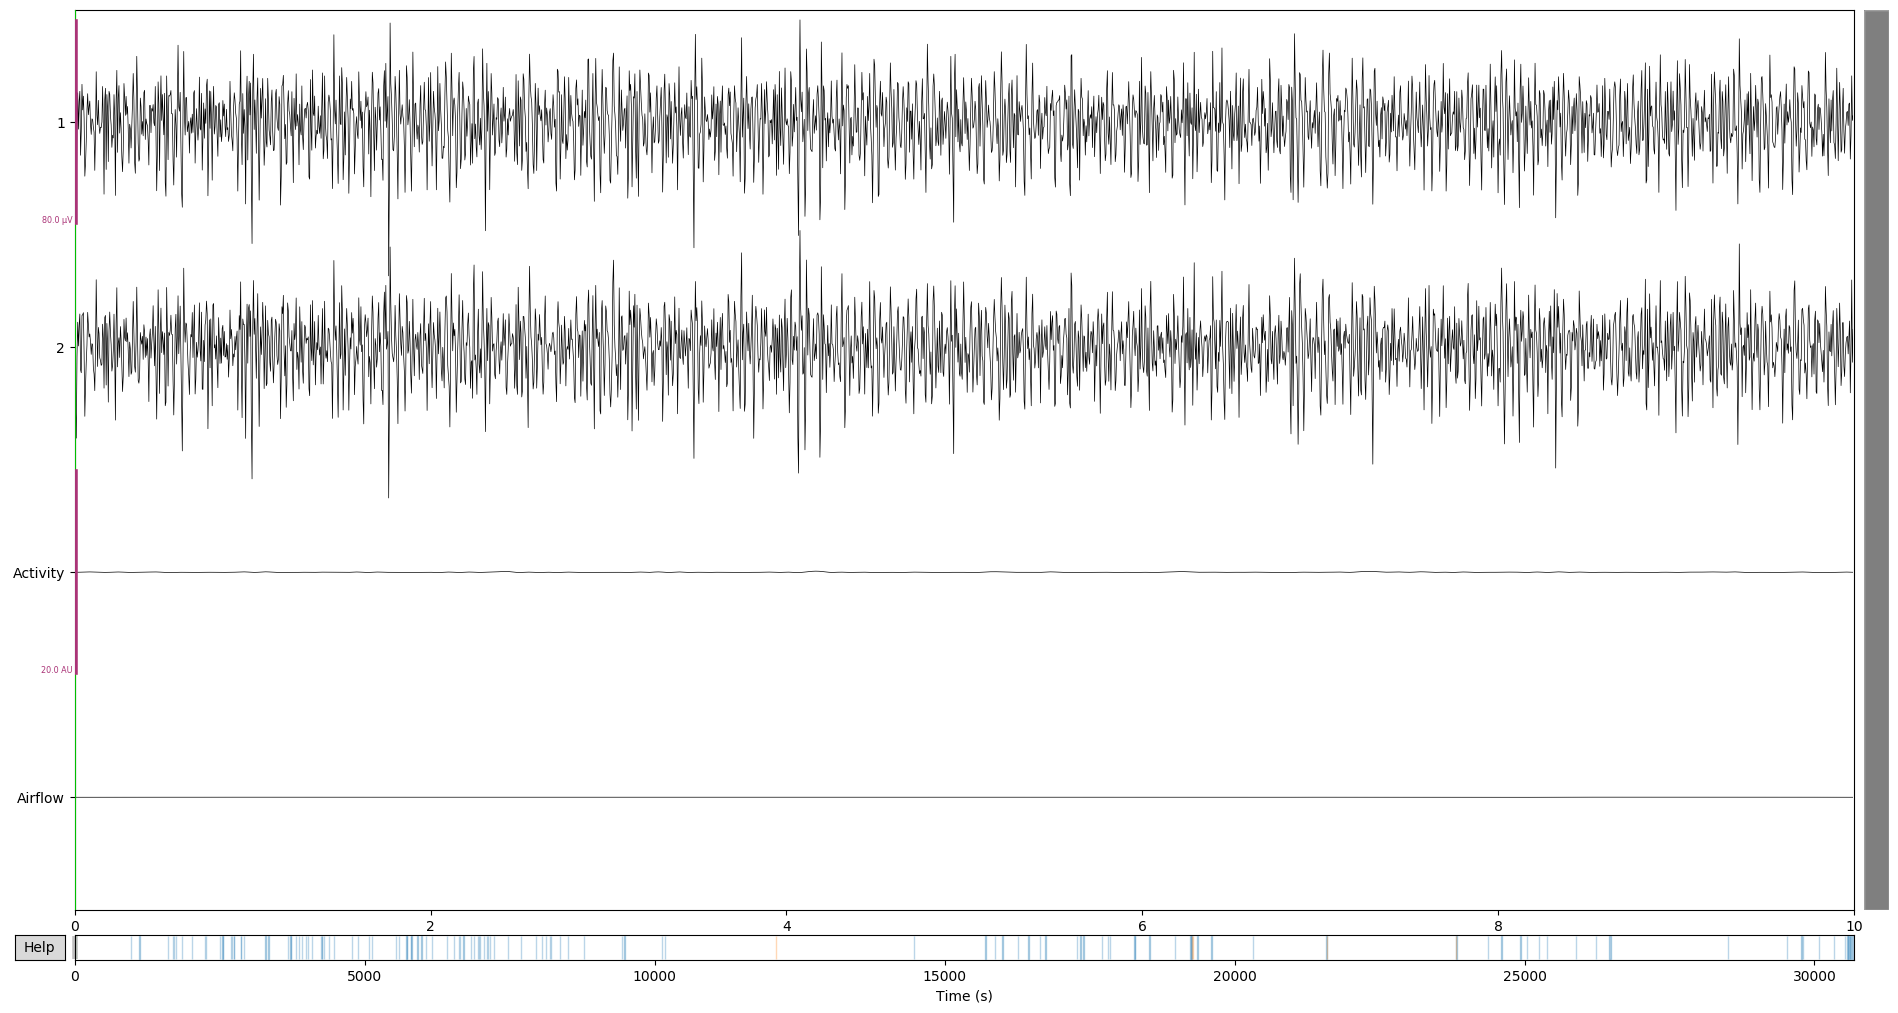

In [14]:
report = generate_bruxism_report(labels, window_length_bruxism, delim = 3)
print(report)
print(raw.annotations)
scalings["misc"]=10
raw.copy().pick(picks=all_channels).load_data().filter(**filter_kwargs_emg).plot(scalings=scalings)


## Display Bursts

In [ ]:
def plotBursts(raw, annotations, annotations_artefacts, plotargs):
    ax1 = plt.subplot(211)
    plotTimeSeries(raw.get_data().T, ax=ax1,**plotargs)
    plotAnnotations(annotations_artefacts, ax=ax1, color="red")
    plotAnnotations(annotations,ax=ax1, text_prop=dict(color="green"), color="green")

    ax1.set_xlim(5145,5165)
    ax2 = plt.subplot(212)
    plotTimeSeries(raw.get_data().T, ax=ax2,**plotargs)
    z = zoom_effect(ax1, ax2)

    from ipywidgets import interact, FloatSlider
    def update_axis(xmin, xmax):
        if xmin<xmax:
            ax1.set_xlim(xmin,xmax)

    i=FloatSlider(min=raw.times[0], max=raw.times[-1], step=10, continuous_update=False)
    ii=FloatSlider(min=raw.times[0], max=raw.times[-1], step=10, continuous_update=False)
    from ipywidgets import FloatSlider
    interact(update_axis,xmin=i, xmax=ii);
    return ax1, ax2

In [ ]:
plt.close("all")

# decimate signal to make it more readible 
raw_ds = raw.copy().resample(100)

%matplotlib widget
scalings=1e-5
plotargs = dict(sfreq=raw_ds.info["sfreq"], scalings=scalings, offset=offset, linewidth=0.5)
plt.figure()
ax1, ax2 = plotBursts(raw_ds, annotations, annotations_artefacts, plotargs);
plt.show()

## Display Episodes

## Transform classif to episodes

1BA07_nuit_hab In this example, an episode of half an hour is detected between 1400 and 3500.

In [17]:
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode
bursts = classif_to_burst(labels, time_interval=window_length)
annotations_episodes = [episode.generate_annotation(orig_time=offset) for episode in burst_to_episode(bursts)]
print(annotations_episodes[:3])

NameError: name 'window_length' is not defined

In [ ]:
#plt.close("all")
scalings=5e-5
print(offset)
plotargs = dict(sfreq=raw_ds.info["sfreq"], scalings=scalings, offset=offset, linewidth=0.5)
plt.figure()
plt.title("artefacts (red), episodes (green)")
ax3, ax4 = plotBursts(raw_ds, annotations_episodes, annotations_artefacts, plotargs)
ax3.set_xlim(10000,10200);
plt.show()

In [ ]:
print(OMA_labels[:100])
OMAs=[]
for elm in np.invert(OMA_labels):
    if elm:
        OMAs.append(2)
    else:
        OMAs.append(0)
print(OMAs[:100])
print(np.sum(OMAs)/2)

good=[]
for elm in np.invert(amplitude_labels):
    if elm:
        good.append(3)
    else:
        good.append(0)

print(np.sum(good)/3)
print(np.sum(np.invert(impedance_labels)))

In [ ]:

from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, episodes_to_list
bursts = classif_to_burst(labels, time_interval=window_length)
li_ep=burst_to_episode(bursts)
lab_ep = episodes_to_list(li_ep, 0.250, int(len(labels)))
print()
print(np.sum(labels))
print(len(labels))
print(len(lab_ep))


In [ ]:
raw = CleanAnnotations(raw)
raw = AnnotateRaw_sliding(raw, good, 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
raw = AnnotateRaw_sliding(raw, OMAs, 
                dict_annotations=dict_annotations, duration=duration_OMA, interval=interval_OMA)
raw = AnnotateRaw_sliding(raw, np.invert(impedance_labels), 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
print("Raw annotated")
raw.plot(scalings=dict(emg=1e-4))

In [ ]:
raw = CleanAnnotations(raw)
raw = AnnotateRaw_sliding(raw, lab_ep, 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
print("Raw annotated")
raw.plot(scalings=dict(emg=1e-4))

In [11]:
%matplotlib qt